[View in Colaboratory](https://colab.research.google.com/github/ankitbit/Deep_Learning/blob/master/Personal%20Projects/Wood_Knot_Clasification_Problem.ipynb)

There is a condition of class imbalance from which our learning algorithm will suffer. What this means is that algorithm will give extra weight to the classification into the class which is having most of the images thereby creating a situation of imbalanced dataset. So, the idea is to read the images from each of the class in such a way that balance can be maintained. The following implementation makes an attempt in that direction.

In [0]:
# Downloading the data and label files
%%capture
! wget http://www.ee.oulu.fi/research/imag/knots/KNOTS/knots.zip
! unzip knots.zip
! rm knots.zip
! wget http://www.ee.oulu.fi/research/imag/knots/KNOTS/names.txt
! wget http://www.ee.oulu.fi/research/imag/knots/KNOTS/ppm.txt
! mkdir ppm
! mkdir names
! mv ppm.txt /content/ppm/
! mv names.txt /content/names/
! pwd

In [0]:
%%capture
! pip install python-resize-image
! pip install Pillow==4.0.0

Considering the above situation, we proceed to collect 10 observations per group in order to create a balanced dataset 

In [0]:
# libraries relevant for data importing, processing

from scipy.misc import imread
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from resizeimage import resizeimage
import pandas as pd
import numpy as np

class_counts = {'dry_knot':0, 'encased_knot':0, 'leaf_knot':0, 'edge_knot':0,
              'sound_knot':0, 'horn_knot':0, 'decayed_knot':0}

In [106]:
# reading the labels and creating a list of filenames to read to avoid imbalance

label_information = pd.read_csv('/content/names/names.txt', sep=" ", 
                                header=None)
labels = label_information[1]
labels = np.array(labels)
class_names = ['dry_knot', 'encased_knot', 'leaf_knot', 'edge_knot',
              'sound_knot', 'horn_knot', 'decayed_knot']
label_information = label_information.drop([2], axis=1)
label_information.columns = ['filenames', 'label']
label_information.groupby(['label']).size()

label
decayed_knot     14
dry_knot         69
edge_knot        65
encased_knot     29
horn_knot        35
leaf_knot        47
sound_knot      179
dtype: int64

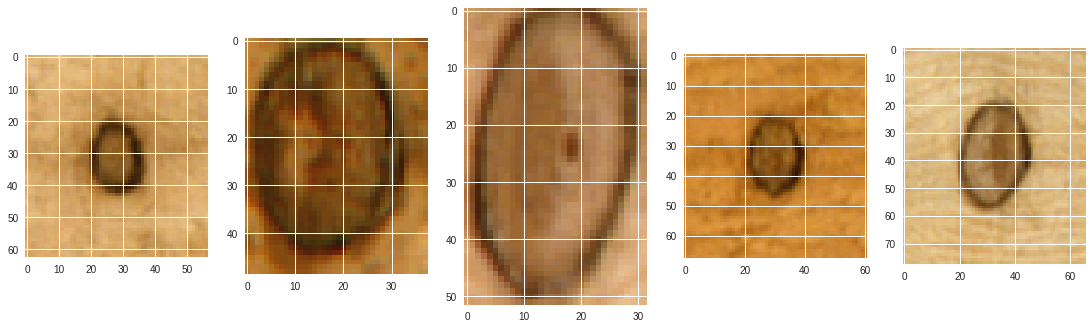

In [107]:
# Visualize original images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path= [filenames[0], filenames[1], filenames[2], filenames[3], filenames[4]]
fig=plt.figure(figsize=(19,19))
columns = 5
rows = 1

for i in range(1, columns*rows +1):
    img = imread(path[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)


In [108]:
# Always run the previous code segment when re-running this code segment
imgs = []
imgs_label = []
filenames = [] # 
path = '/content'

for index, row in label_information.iterrows():
  if class_counts[row['label']]<= 16:    
    with open(row['filenames'], 'r+b') as f:
      with Image.open(f) as image:
        old_size = image.size
        new_size = (80, 80)
        new_image = Image.new("RGB", new_size)
        new_image.paste(image)
        new_image.save(row['filenames'], image.format)
      img = imread(row['filenames'])
      imgs.append(img)
      imgs_label.append(row['label'])
      filenames.append(row['filenames'])
    class_counts[row['label']]+= 1
  else:
    continue

imgs = np.array(imgs)
imgs = imgs/255
print('Shape of Input Images',imgs.shape)

Shape of Input Images (116, 80, 80, 3)


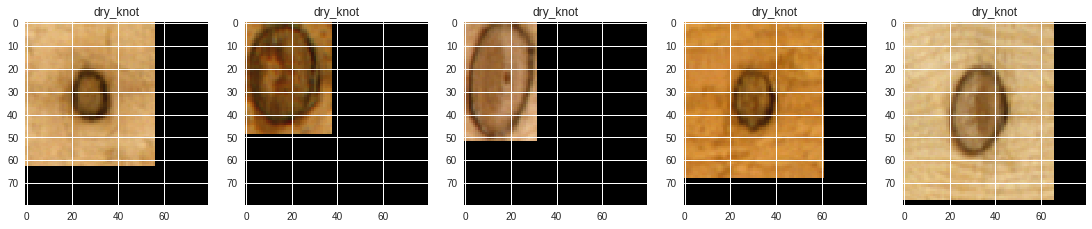

In [109]:

# Visualize resized images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path= [filenames[0], filenames[1], filenames[2], filenames[3], filenames[4]]
fig = plt.figure(figsize=(19,19))
columns = 5
rows = 1

for i in range(1, columns*rows +1):
    img = imread(path[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(imgs_label[i])

In [110]:

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
label_binary = encoder.fit_transform(imgs_label)
Y_train, Y_test = train_test_split(label_binary, test_size=0.2, random_state=42)
print(Y_train.shape)
print(Y_test.shape)

(92, 7)
(24, 7)


In [0]:
# creating training and test set of images
X_train, X_test = train_test_split(imgs, test_size=0.2, random_state=42)


In [0]:
num_classes = label_binary.shape[1]

In [0]:
# Convolutional Neural Network Based Model for Identifying Faulty Wood Planks
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, Conv3D, Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras import backend as K
K.set_image_dim_ordering('th')

In [119]:

# Create the model
model = Sequential()
model.add(Conv2D(512, (4, 4),input_shape=(80, 80, 3), padding='same', 
                 use_bias=True, 
                 activation='relu', kernel_regularizer = regularizers.l2(0.001),
                 kernel_constraint=maxnorm(3)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (4, 4),input_shape=(32, 32, 3), padding='same', 
                 activation='relu', kernel_regularizer = regularizers.l2(0.001),
                 kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (4, 4), activation='relu', 
                 padding='same', kernel_regularizer = regularizers.l2(0.001),
                 kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (4, 4),input_shape=(32, 32, 3), padding='same', 
                 activation='relu', kernel_constraint=maxnorm(3)))
model.add(Conv2D(64, (4, 4), activation='relu', padding='same', 
                 kernel_regularizer = regularizers.l2(0.001),
                 kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu', 
                kernel_regularizer = regularizers.l2(0.001),
                kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))
# Compile model
epochs = 600
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=True)
#sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 512, 80, 3)        655872    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512, 80, 3)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 80, 3)        2097408   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256, 80, 3)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 80, 3)        524416    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 80, 3)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 80, 3)        262272    
__________

In [120]:
# Fit the model
history = model.fit(X_train, Y_train, validation_split=0.2, 
                    epochs=epochs, batch_size=128)

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 73 samples, validate on 19 samples
Epoch 1/600
73/73 [==============================] - 4s 52ms/step - loss: 3.1276 - acc: 0.1233 - val_loss: 3.1230 - val_acc: 0.2632
Epoch 2/600
73/73 [==============================] - 0s 4ms/step - loss: 3.1261 - acc: 0.1644 - val_loss: 3.1228 - val_acc: 0.2632
Epoch 3/600
73/73 [==============================] - 0s 4ms/step - loss: 3.1242 - acc: 0.1781 - val_loss: 3.1226 - val_acc: 0.2105
Epoch 4/600
73/73 [==============================] - 0s 4ms/step - loss: 3.1255 - acc: 0.1370 - val_loss: 3.1223 - val_acc: 0.2105
Epoch 5/600
73/73 [==============================] - 0s 4ms/step - loss: 3.1265 - acc: 0.1370 - val_loss: 3.1220 - val_acc: 0.2105
Epoch 6/600
73/73 [==============================] - 0s 4ms/step - loss: 3.1249 - acc: 0.1370 - val_loss: 3.1217 - val_acc: 0.2105
Epoch 7/600
73/73 [==============================] - 0s 4ms/step - loss: 3.1259 - acc: 0.1096 - val_loss: 3.1213 - val_acc: 0.2105
Epoch 8/600
73/73 [===================

Text(0.5,1,'Validation Loss')

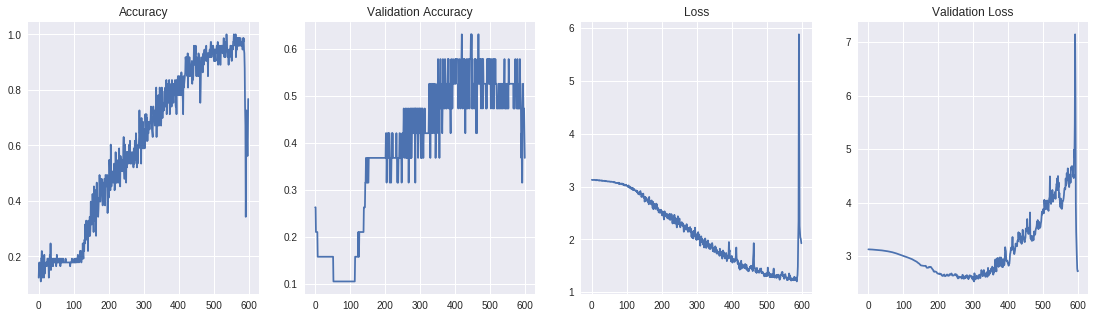

In [121]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(19,5))
columns = 4
rows = 1

fig.add_subplot(rows, columns, 1)
plt.plot(history.history['acc'])
plt.title('Accuracy')
fig.add_subplot(rows, columns, 2)
plt.plot(history.history['val_acc'])
plt.title('Validation Accuracy')
fig.add_subplot(rows, columns, 3)
plt.plot(history.history['loss'])
plt.title('Loss')
fig.add_subplot(rows, columns, 4)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')

In [122]:
#Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
#Compute probabilities
Y_pred = model.predict(X_test)
#Assign most probable label
y_pred = np.argmax(Y_pred, axis=1)
#Plot statistics
print ('Analysis of results')

print(classification_report(np.argmax(Y_test,axis=1), y_pred))
print('Confusion Matrix\n',confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

Analysis of results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      0.60      0.55         5
           2       0.60      1.00      0.75         3
           3       0.50      0.50      0.50         2
           4       0.50      0.33      0.40         3
           5       0.14      0.50      0.22         2
           6       0.00      0.00      0.00         4

   micro avg       0.38      0.38      0.38        24
   macro avg       0.32      0.42      0.35        24
weighted avg       0.30      0.38      0.32        24

Confusion Matrix
 [[0 0 1 0 1 2 1]
 [0 3 0 1 0 1 0]
 [0 0 3 0 0 0 0]
 [0 0 0 1 0 1 0]
 [0 0 1 0 1 1 0]
 [0 0 0 0 0 1 1]
 [0 3 0 0 0 1 0]]


# Transfer Learning 

In [123]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import os
import numpy as np

model = VGG16(weights='imagenet', include_top=False)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

In [24]:
! pip install -U scikit-learn

    100% |████████████████████████████████| 5.3MB 7.9MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


In [124]:
# Always run the previous code segment when re-running this code segment

class_counts = {'dry_knot':0, 'encased_knot':0, 'leaf_knot':0, 'edge_knot':0,
              'sound_knot':0, 'horn_knot':0, 'decayed_knot':0}
imgs_label = []
path = '/content'
filenames = []
feature_list = []

for index, row in label_information.iterrows():
  if class_counts[row['label']]<= 30:     
    
    imgs_label.append(row['label'])
    filenames.append(row['filenames'])
    img = image.load_img(row['filenames'], target_size=(70,70))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    feature = model.predict(img_data)
    feature = np.array(feature)
    feature_list.append(feature.flatten())
    class_counts[row['label']]+= 1
  else:
    continue
    
feature_list = np.array(feature_list)
print('Shape of Input Images',feature_list.shape)

Shape of Input Images (198, 2048)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
import warnings
warnings.filterwarnings('ignore')

features = StandardScaler().fit_transform(feature_list)
features[:2][:2]
est = KBinsDiscretizer(n_bins=3, encode='ordinal', 
                       strategy = 'uniform').fit(features)
features = est.transform(features)

In [0]:

x_train, x_test, y_train, y_test = train_test_split(
    features , imgs_label, test_size=0.12, random_state=42)

In [127]:
print('Labels on Test Set:', y_test)

Labels on Test Set: ['decayed_knot', 'edge_knot', 'dry_knot', 'edge_knot', 'horn_knot', 'edge_knot', 'edge_knot', 'dry_knot', 'dry_knot', 'horn_knot', 'horn_knot', 'dry_knot', 'encased_knot', 'encased_knot', 'edge_knot', 'encased_knot', 'edge_knot', 'dry_knot', 'horn_knot', 'leaf_knot', 'edge_knot', 'horn_knot', 'encased_knot', 'sound_knot']


In [0]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svc_model = SVC(kernel='linear').fit(x_train, y_train)
y_pred = svc_model.predict(x_test)

In [129]:
print(classification_report(y_test, y_pred))
print('Confusion Matrix \n')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

decayed_knot       1.00      1.00      1.00         1
    dry_knot       1.00      1.00      1.00         5
   edge_knot       1.00      0.86      0.92         7
encased_knot       1.00      0.75      0.86         4
   horn_knot       0.75      0.60      0.67         5
   leaf_knot       0.33      1.00      0.50         1
  sound_knot       0.50      1.00      0.67         1

   micro avg       0.83      0.83      0.83        24
   macro avg       0.80      0.89      0.80        24
weighted avg       0.90      0.83      0.85        24

Confusion Matrix 

[[1 0 0 0 0 0 0]
 [0 5 0 0 0 0 0]
 [0 0 6 0 1 0 0]
 [0 0 0 3 0 0 1]
 [0 0 0 0 3 2 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]]


We have an idea of testing the performance of the trained model on the remaining set of images that we had skipped to read in the beginning because of the fact that we wished to avoid the situation of class imbalance by reading similar number of images from each of the classes. Now, the remaining images can be once again read and processed to act as our new test on which we can examine the performance of our trained model.

In [130]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import os
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

# Always run the previous code segment when re-running this code segment
imgs = []
test_imgs_label = []
test_filenames = [] #
test_feature_list = []
path = '/content'
test_class_counts = {'dry_knot':0, 'encased_knot':0, 'leaf_knot':0, 'edge_knot':0,
              'sound_knot':0, 'horn_knot':0, 'decayed_knot':0}


# Always run the previous code segment when re-running this code segment

for index, row in label_information.iterrows():
  
  if row['filenames'] not in filenames:
    test_imgs_label.append(row['label'])
    test_filenames.append(row['filenames'])
    img = image.load_img(row['filenames'], target_size=(70,70))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    feature = model.predict(img_data)
    feature = np.array(feature)
    test_feature_list.append(feature.flatten())
    test_class_counts[row['label']]+= 1
  else:
    continue
    
test_feature_list = np.array(test_feature_list)
print('Shape of Input Images',test_feature_list.shape)


Shape of Input Images (240, 2048)


In [131]:
print(test_class_counts)

{'dry_knot': 38, 'encased_knot': 0, 'leaf_knot': 16, 'edge_knot': 34, 'sound_knot': 148, 'horn_knot': 4, 'decayed_knot': 0}


In [0]:
test_features = StandardScaler().fit_transform(test_feature_list)
test_features[:2][:2]
est = KBinsDiscretizer(n_bins=3, encode='ordinal', 
                       strategy = 'uniform').fit(test_features)
test_features = est.transform(test_features)

y_pred = svc_model.predict(test_features)

In [133]:
print(classification_report(y_pred, test_imgs_label))
print('Confusion Matrix \n')
print(confusion_matrix(test_imgs_label, y_pred))

              precision    recall  f1-score   support

decayed_knot       0.00      0.00      0.00         8
    dry_knot       0.71      0.73      0.72        37
   edge_knot       0.65      0.96      0.77        23
encased_knot       0.00      0.00      0.00         9
   horn_knot       1.00      0.31      0.47        13
   leaf_knot       0.88      0.56      0.68        25
  sound_knot       0.82      0.98      0.89       125

   micro avg       0.79      0.79      0.79       240
   macro avg       0.58      0.50      0.51       240
weighted avg       0.75      0.79      0.75       240

Confusion Matrix 

[[  0   0   0   0   0   0   0]
 [  1  27   1   4   0   3   2]
 [  2   0  22   0   6   3   1]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   4   0   0]
 [  0   0   0   0   2  14   0]
 [  5  10   0   5   1   5 122]]
